In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras import applications

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import h5py
import os

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Normalize pixel values to the range [0, 1]
data_gen = ImageDataGenerator(rescale=1.0/255)

In [4]:
'''
Directory structure for images:

a5_images
├── validation
│   ├── car
│   └── other
└── train
    ├── car
    └── other
'''
# Dataset from PASCAL Visual Object Classes Challenge 2010 (VOC2010)
imgdir = 'a5_images'
imgdir_aug = imgdir + '_aug'

# Define the original folder name and new folder name
original_folder = imgdir
new_folder = imgdir_aug

# Duplicate the folder
shutil.copytree(original_folder, new_folder)

img_size = 64
batch_size = 64

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=48,
        shuffle=True)

valid_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=48,
        shuffle=True)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


(64, 64, 64, 3)


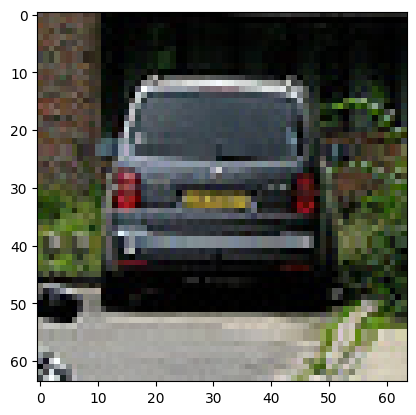

In [15]:
Xbatch, Ybatch = train_generator.next()

print(Xbatch.shape)

plt.imshow(Xbatch[7])

In [27]:
from keras.regularizers import l2

def create_conv_net(learning_rate=0.0001, l2_reg=0.01):
  
  num_classes = 2

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                   activation='relu',
                   input_shape=(img_size, img_size, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate),
                metrics=['accuracy'])

  return model

In [35]:
# Define the hyperparameters to search
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'l2_reg': [0.001, 0.01, 0.1]
}

# Manual grid search
best_score = 0
best_params = None
best_model = None
best_history = None

for learning_rate in param_grid['learning_rate']:
    for l2_reg in param_grid['l2_reg']:
        # Create the model with current hyperparameters
        model = create_conv_net(learning_rate=learning_rate, l2_reg=l2_reg)

        # Train the model
        history = model.fit(x=train_generator, validation_data=valid_generator, epochs=30, batch_size=batch_size, verbose=0)

        # Evaluate the model on validation data
        score = model.evaluate(valid_generator, verbose=0)[1]  # Get accuracy
        print(f'Optimizer: Adam, Learning Rate: {learning_rate}, L2 Reg: {l2_reg}, Accuracy: {score}')
        
        # Check if current hyperparameters result in a better score
        if score > best_score:
            best_score = score
            best_params = {'learning_rate': learning_rate, 'l2_reg': l2_reg}
            best_model = model
            best_history = history

Optimizer: Adam, Learning Rate: 0.001, L2 Reg: 0.001, Accuracy: 0.7621527910232544
Optimizer: Adam, Learning Rate: 0.001, L2 Reg: 0.01, Accuracy: 0.8038194179534912
Optimizer: Adam, Learning Rate: 0.001, L2 Reg: 0.1, Accuracy: 0.7934027910232544
Optimizer: Adam, Learning Rate: 0.0001, L2 Reg: 0.001, Accuracy: 0.7934027910232544
Optimizer: Adam, Learning Rate: 0.0001, L2 Reg: 0.01, Accuracy: 0.8003472089767456
Optimizer: Adam, Learning Rate: 0.0001, L2 Reg: 0.1, Accuracy: 0.7760416865348816
Optimizer: Adam, Learning Rate: 1e-05, L2 Reg: 0.001, Accuracy: 0.765625
Optimizer: Adam, Learning Rate: 1e-05, L2 Reg: 0.01, Accuracy: 0.7482638955116272
Optimizer: Adam, Learning Rate: 1e-05, L2 Reg: 0.1, Accuracy: 0.7291666865348816


In [38]:
# Print the best parameters and corresponding accuracy
print("Best validation accuracy : %f using hyperparameters %s" % (best_score, best_params))

# Save the best weights
best_model.save_weights("best_model_weights.h5")

Best validation accuracy : 0.803819 using hyperparameters {'learning_rate': 0.001, 'l2_reg': 0.01}


Blue: train loss, Orange: valid loss


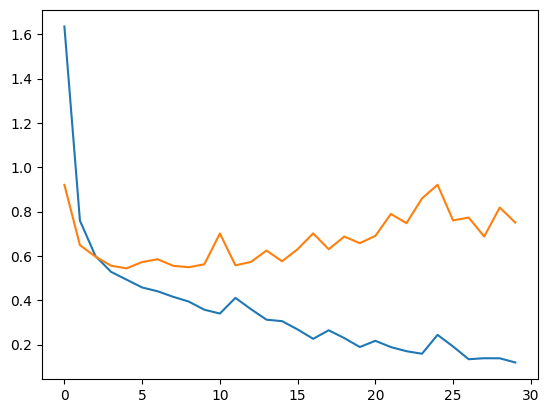

In [39]:
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
print("Blue: train loss, Orange: valid loss")

Blue: train accuracy, Orange: valid accuracy


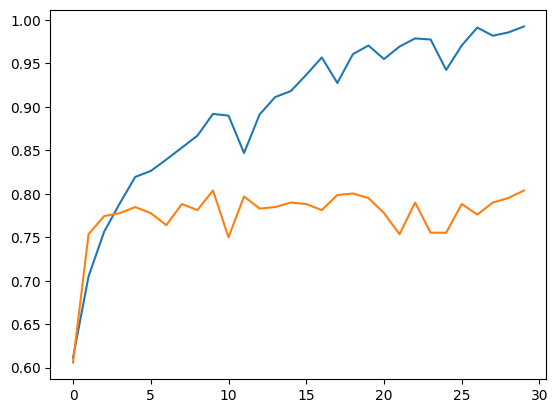

In [40]:
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
print("Blue: train accuracy, Orange: valid accuracy")

In [41]:
aug_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    channel_shift_range=50
)

train_generator_aug = aug_gen.flow_from_directory(
        imgdir_aug + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


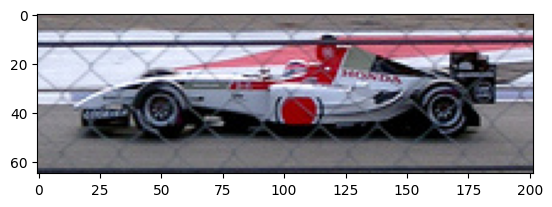

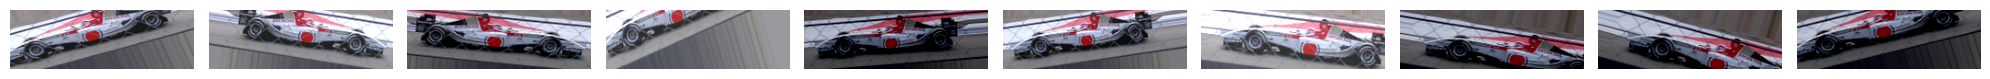

In [42]:
# Choose a random image from the car directory
chosen_image = random.choice(os.listdir('a5_images_aug/train/car'))

image_path = 'a5_images_aug/train/car/' + chosen_image

image = np.expand_dims(plt.imread(image_path),0)

plt.imshow(image[0])

# Function for plotting images (taken from Tensorflow)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Augmentation
aug_iter = aug_gen.flow(image)

aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

plotImages(aug_images)

In [44]:
path_car = 'a5_images_aug/train/car'
path_other = 'a5_images_aug/train/other'

for filename in os.listdir(path_car):
  image_path = path_car + "/" + filename
  image = np.expand_dims(plt.imread(image_path), 0)
  try:
    aug_iter = aug_gen.flow(
        image,
        save_to_dir=path_car,
        save_prefix="aug",
        save_format="jpg",
    )
  except ValueError:
    pass
  aug_images = [
      next(aug_iter)[0].astype(np.uint8)
      for i in range(10)  # Change range(x) for generating x augmentations
  ]
  print("Created augmented images for:", filename)

for filename in os.listdir(path_other):
  image_path = path_other + "/" + filename
  image = np.expand_dims(plt.imread(image_path), 0)
  try:
    aug_iter = aug_gen.flow(
        image,
        save_to_dir=path_other,
        save_prefix="aug",
        save_format="jpg",
    )
  except ValueError:
    pass
  aug_images = [
      next(aug_iter)[0].astype(np.uint8)
      for i in range(10)  # Change range(x) for generating x augmentations
  ]
  print("Created augmented images for:", filename)

Created augmented images for: 0000.jpg
Created augmented images for: 0001.jpg
Created augmented images for: 0002.jpg
Created augmented images for: 0003.jpg
Created augmented images for: 0004.jpg
Created augmented images for: 0005.jpg
Created augmented images for: 0006.jpg
Created augmented images for: 0007.jpg
Created augmented images for: 0008.jpg
Created augmented images for: 0009.jpg
Created augmented images for: 0010.jpg
Created augmented images for: 0011.jpg
Created augmented images for: 0012.jpg
Created augmented images for: 0013.jpg
Created augmented images for: 0014.jpg
Created augmented images for: 0015.jpg
Created augmented images for: 0016.jpg
Created augmented images for: 0017.jpg
Created augmented images for: 0018.jpg
Created augmented images for: 0019.jpg
Created augmented images for: 0020.jpg
Created augmented images for: 0021.jpg
Created augmented images for: 0022.jpg
Created augmented images for: 0023.jpg
Created augmented images for: 0024.jpg
Created augmented images 

In [45]:
# Now the training will be using the original + the augmented images
train_generator_new = data_gen.flow_from_directory(
        imgdir_aug + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=48,
        shuffle=True)

Found 12562 images belonging to 2 classes.


In [46]:
# Now train with the best seen h-parameters and augmented images
cnn_model_aug = create_conv_net(learning_rate=0.001, l2_reg=0.01)

history_aug = cnn_model_aug.fit(x=train_generator_new, 
            validation_data=valid_generator,
            batch_size=batch_size,
            epochs=30,
            verbose=1,
            );

cnn_model_aug.save_weights("cnn_weights_aug.h5")

Epoch 1/30
197/197 [==============================] - 7s 32ms/step - loss: 0.7923 - accuracy: 0.6977 - val_loss: 0.5551 - val_accuracy: 0.7708
Epoch 2/30
197/197 [==============================] - 6s 31ms/step - loss: 0.5014 - accuracy: 0.7833 - val_loss: 0.5229 - val_accuracy: 0.7795
Epoch 3/30
197/197 [==============================] - 6s 32ms/step - loss: 0.4644 - accuracy: 0.8098 - val_loss: 0.4998 - val_accuracy: 0.8038
Epoch 4/30
197/197 [==============================] - 6s 31ms/step - loss: 0.4481 - accuracy: 0.8188 - val_loss: 0.4773 - val_accuracy: 0.8229
Epoch 5/30
197/197 [==============================] - 6s 31ms/step - loss: 0.4251 - accuracy: 0.8330 - val_loss: 0.4763 - val_accuracy: 0.8090
Epoch 6/30
197/197 [==============================] - 6s 31ms/step - loss: 0.3994 - accuracy: 0.8476 - val_loss: 0.4995 - val_accuracy: 0.8142
Epoch 7/30
197/197 [==============================] - 6s 32ms/step - loss: 0.3954 - accuracy: 0.8575 - val_loss: 0.4911 - val_accuracy: 0.8073

Blue: train loss, Orange: valid loss


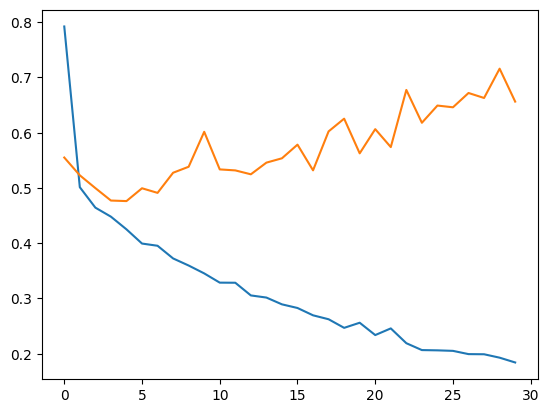

In [47]:
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
print("Blue: train loss, Orange: valid loss")

Blue: train accuracy, Orange: valid accuracy


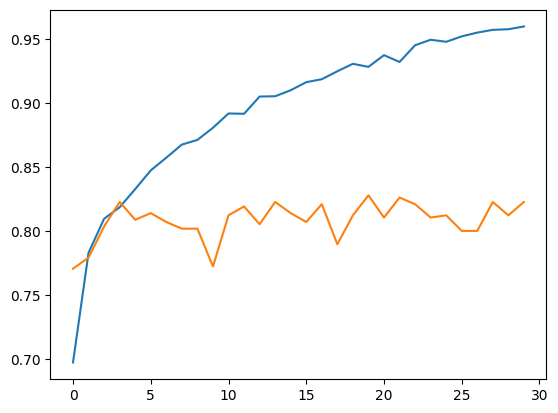

In [48]:
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
print("Blue: train accuracy, Orange: valid accuracy")

In [49]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


[[('n04065272', 'recreational_vehicle', 0.6170336),
  ('n03977966', 'police_van', 0.12691468),
  ('n03769881', 'minibus', 0.078712754),
  ('n02701002', 'ambulance', 0.06957302),
  ('n03796401', 'moving_van', 0.02706422)]]

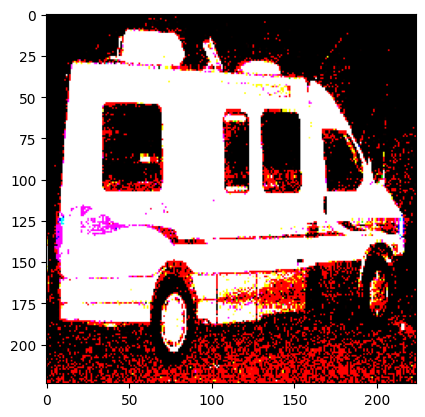

In [78]:
img = load_img('a5_images/validation/car/0036.jpg', target_size=(224,224))
img = img_to_array(img)
img = preprocess_input(img)
img = img.reshape(1, 224, 224, 3)

plt.imshow(img[0])

predictions = vggmodel.predict(img)
decode_predictions(predictions)

In [79]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_vgg16_features(feature_extr, data_gen, img_path, write_path):
  img_gen = data_gen.flow_from_directory(
        img_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=48,
        shuffle=False)
  
  cnn_features = feature_extr.predict(img_gen)

  with open(write_path, 'wb') as f:

    np.save(f, cnn_features)
  

create_vgg16_features(feature_extractor, vgg_data_gen, imgdir + '/train', 'train.txt')
create_vgg16_features(feature_extractor, vgg_data_gen, imgdir + '/validation', 'valid.txt')

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

def train_on_cnnfeatures(path_train, path_valid):
  with open(path_train, 'rb') as f:
    the_data_train = np.load(f)

  with open(path_valid, 'rb') as f:
    the_data_valid = np.load(f)

  num_classes = 2

  model = Sequential()
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

  history_vgg16 = model.fit(x=the_data_train, y=get_labels(1600),
            validation_data=(the_data_valid, get_labels(576)),
            batch_size=batch_size,
            epochs=50,
            verbose=1,
            );

  model.save_weights("vgg16_weights.h5")
  return(history_vgg16)

history_vgg16 = train_on_cnnfeatures('train.txt', 'valid.txt')

Found 1600 images belonging to 2 classes.
25/25 [==============================] - 2s 42ms/step
Found 576 images belonging to 2 classes.
9/9 [==============================] - 0s 42ms/step
Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 4.6948 - accuracy: 0.8037 - val_loss: 1.9181 - val_accuracy: 0.8698
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5492 - accuracy: 0.9269 - val_loss: 1.0164 - val_accuracy: 0.8872
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9719 - val_loss: 1.0379 - val_accuracy: 0.8785
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9950 - val_loss: 1.0281 - val_accuracy: 0.8767
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 1.0466 - val_accuracy: 0.8785
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 1

Blue: train loss, Orange: valid loss


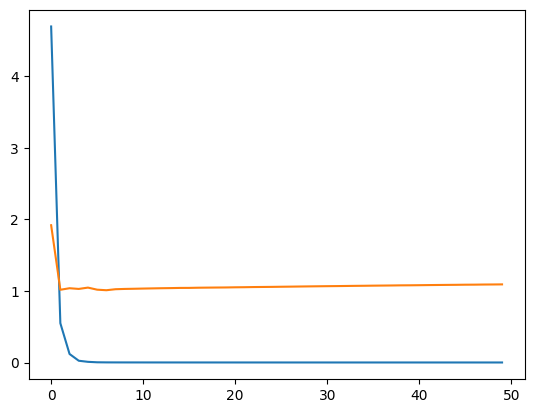

In [80]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
print("Blue: train loss, Orange: valid loss")

Blue: train accuracy, Orange: valid accuracy


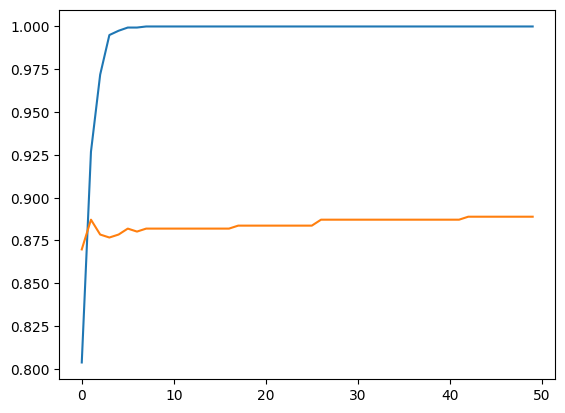

In [81]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
print("Blue: train accuracy, Orange: valid accuracy")